# 🤖 TEKBOT Robotics Challenge - Détection d'objets avec YOLOv8

## 🎯 Objectif
Dans ce notebook, nous allons créer un détecteur d'objets capable de :
- **Localiser** plusieurs objets dans une image (bounding boxes)
- **Identifier** le type de chaque objet détecté  
- **Fonctionner en temps réel** pour la robotique

## 🔍 Détection vs Classification
| Aspect | Classification | Détection |
|--------|---------------|-----------|
| **Sortie** | 1 classe par image | N objets + positions |
| **Localisation** | ❌ | ✅ Bounding boxes |
| **Objets multiples** | ❌ | ✅ Plusieurs objets |
| **Complexité** | Simple | Plus complexe |

## ⚡ Pourquoi YOLOv8 ?
- **You Only Look Once** : Une seule passe dans le réseau
- **Temps réel** : >100 FPS sur GPU
- **Précis** : State-of-the-art en détection
- **Facile** : API simple avec Ultralytics
- **Robotique** : Parfait pour Jetson Nano

## 1. Installation et imports

In [ ]:
# Installation des dépendances
!pip install -qU ultralytics opencv-python matplotlib pillow

# Imports
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from ultralytics import YOLO

# Vérification GPU
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 122.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 128.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/

## 🏗️ Architecture YOLOv8

### Principe YOLO :
1. **Divise l'image** en grille (ex: 13x13)
2. **Chaque cellule** prédit plusieurs objets potentiels
3. **Suppression non-maximale** : Garde les meilleures détections
4. **Une seule inférence** : Très rapide !

### Composants YOLOv8 :
- **Backbone** : CSPDarknet (extraction de features)
- **Neck** : PANet (fusion multi-échelle)  
- **Head** : Découplé (classification + régression)

### Avantages pour la robotique :
- **Latence faible** : <10ms sur Jetson Nano
- **Robuste** : Fonctionne sur objets partiels
- **Flexible** : Facile à réentraîner
- **Optimisé** : Export TensorRT natif


In [ ]:
# Chargement du modèle YOLOv8 pré-entraîné
model = YOLO('yolov8n.pt')  # nano version (plus rapide)
# Alternatives : yolov8s.pt (small), yolov8m.pt (medium), yolov8l.pt (large)

print("✅ Modèle YOLOv8n chargé !")
print(f"Classes supportées : {len(model.names)} classes")

# Affichage de quelques classes COCO
coco_classes = list(model.names.values())
print(f"\nExemples de classes COCO :")
for i, classe in enumerate(coco_classes[:20]):
    print(f"{i}: {classe}")

100%|██████████| 6.25M/6.25M [00:00<00:00, 237MB/s]

✅ Modèle YOLOv8n chargé !
Classes supportées : 80 classes

Exemples de classes COCO :
0: person
1: bicycle
2: car
3: motorcycle
4: airplane
5: bus
6: train
7: truck
8: boat
9: traffic light
10: fire hydrant
11: stop sign
12: parking meter
13: bench
14: bird
15: cat
16: dog
17: horse
18: sheep
19: cow


## 3. Téléchargement du dataset COCO128


In [ ]:
# Le dataset COCO128 est automatiquement téléchargé par Ultralytics
# C'est un sous-ensemble de 128 images de COCO pour les tests rapides

# Vérification du dataset
import yaml
from pathlib import Path

# COCO128 sera téléchargé automatiquement lors du premier entraînement
print("📁 Dataset COCO128 sera téléchargé automatiquement")
print("Contient 128 images avec annotations YOLO")

# Classes simulant des déchets dans COCO
waste_relevant_classes = {
    39: 'bottle',      # Bouteille plastique → Recyclable
    41: 'cup',         # Gobelet → Ménager
    73: 'book',        # Livre → Recyclable (papier)
    67: 'cell_phone',  # Téléphone → Dangereux (électronique)
    64: 'mouse',       # Souris → Dangereux (électronique)
    66: 'keyboard',    # Clavier → Dangereux (électronique)
}

print(f"\n♻️ Classes pertinentes pour les déchets :")
for class_id, name in waste_relevant_classes.items():
    print(f"  {class_id}: {name}")

📁 Dataset COCO128 sera téléchargé automatiquement
Contient 128 images avec annotations YOLO

♻️ Classes pertinentes pour les déchets :
  39: bottle
  41: cup
  73: book
  67: cell_phone
  64: mouse
  66: keyboard


## 📁 Structure du dataset YOLO

### Organisation des fichiers :
```
dataset/
├── images/
│   ├── train/
│   │   ├── image1.jpg
│   │   └── image2.jpg
│   └── val/
│       ├── image3.jpg
│       └── image4.jpg
├── labels/
│   ├── train/
│   │   ├── image1.txt
│   │   └── image2.txt
│   └── val/
│       ├── image3.txt
│       └── image4.txt
└── data.yaml
```

### Format des annotations (.txt) :
class_id center_x center_y width height
0 0.5 0.3 0.2 0.4
1 0.7 0.8 0.1 0.15

### Coordonnées normalisées :
- **center_x, center_y** : Centre de l'objet (0 à 1)
- **width, height** : Taille de l'objet (0 à 1)
- **Relatif à l'image** : Indépendant de la résolution











## 4. Configuration de l'entraînement

In [ ]:
# Configuration de l'entraînement
train_config = {
    'data': 'coco128.yaml',  # Dataset COCO128
    'epochs': 10,            # Nombre d'époques (court pour la démo)
    'imgsz': 640,           # Taille d'image
    'batch': 16,            # Taille de batch
    'device': 0 if torch.cuda.is_available() else 'cpu',
    'workers': 4,           # Nombre de workers pour le chargement
    'project': 'waste_detection',  # Nom du projet
    'name': 'yolov8_waste',        # Nom de l'expérience
    'save_period': 5,       # Sauvegarde tous les 5 epochs
    'patience': 5,          # Early stopping
    'lr0': 0.01,           # Learning rate initial
    'warmup_epochs': 1,     # Epochs de warmup
}

print("⚙️ Configuration d'entraînement :")
for key, value in train_config.items():
    print(f"  {key}: {value}")

⚙️ Configuration d'entraînement :
  data: coco128.yaml
  epochs: 10
  imgsz: 640
  batch: 16
  device: 0
  workers: 4
  project: waste_detection
  name: yolov8_waste
  save_period: 5
  patience: 5
  lr0: 0.01
  warmup_epochs: 1


## 5. Entraînement du modèle

In [ ]:
# Entraînement du modèle
print("🚀 Début de l'entraînement YOLOv8 !")
print("-" * 50)

# Lancement de l'entraînement
results = model.train(
    data='coco128.yaml',
    epochs=10,
    imgsz=640,
    batch=16,
    device=0 if torch.cuda.is_available() else 'cpu',
    project='waste_detection',
    name='yolov8_waste',
    save_period=5,
    patience=5,
    lr0=0.01,
    warmup_epochs=1,
    verbose=True
)

print("✅ Entraînement terminé !")
print(f"Modèle sauvegardé dans : {results.save_dir}")

🚀 Début de l'entraînement YOLOv8 !
--------------------------------------------------
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco128.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_waste, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_m

100%|██████████| 6.66M/6.66M [00:00<00:00, 381MB/s]
Unzipping /content/datasets/coco128.zip to /content/datasets/coco128...: 100%|██████████| 263/263 [00:00<00:00, 4305.59file/s]

Dataset download success ✅ (1.2s), saved to /content/datasets



100%|██████████| 755k/755k [00:00<00:00, 88.9MB/s]


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

Model summary: 129 layers, 3,157,200 parameters, 3,157,184 gradients, 8.9 GFLOPs

Transferred 355/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 320MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 884.9±543.2 MB/s, size: 50.9 KB)


train: Scanning /content/datasets/coco128/labels/train2017... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<00:00, 2477.86it/s]

train: New cache created: /content/datasets/coco128/labels/train2017.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 441.1±158.7 MB/s, size: 52.5 KB)


val: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]


Plotting labels to waste_detection/yolov8_waste/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to waste_detection/yolov8_waste
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.31G      1.185      1.381      1.194         83        640: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        128        929       0.62      0.577      0.607      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.71G      1.158      1.321      1.212        120        640: 100%|██████████| 8/8 [00:02<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

                   all        128        929      0.639       0.58      0.618      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.74G      1.167      1.284      1.181        115        640: 100%|██████████| 8/8 [00:01<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

                   all        128        929      0.669      0.565      0.633      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.74G      1.139      1.292       1.19        116        640: 100%|██████████| 8/8 [00:02<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        128        929       0.67      0.589      0.647      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.74G       1.14      1.241      1.207         68        640: 100%|██████████| 8/8 [00:01<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        128        929      0.668      0.618       0.66      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.74G      1.144      1.222      1.187         92        640: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]

                   all        128        929       0.68      0.625       0.68      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.76G      1.114       1.16      1.179        117        640: 100%|██████████| 8/8 [00:01<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

                   all        128        929      0.674      0.636       0.68      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.76G      1.101      1.164       1.17         66        640: 100%|██████████| 8/8 [00:02<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

                   all        128        929      0.678      0.645      0.687       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.78G      1.167       1.18      1.197        147        640: 100%|██████████| 8/8 [00:01<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        128        929      0.678      0.658      0.695      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.78G      1.082       1.12      1.143        111        640: 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        128        929      0.678      0.658      0.701      0.529



10 epochs completed in 0.011 hours.
Optimizer stripped from waste_detection/yolov8_waste/weights/last.pt, 6.5MB
Optimizer stripped from waste_detection/yolov8_waste/weights/best.pt, 6.5MB

Validating waste_detection/yolov8_waste/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


                   all        128        929      0.679      0.657      0.703      0.529
                person         61        254      0.776      0.683      0.777      0.564
               bicycle          3          6      0.935      0.333      0.381      0.333
                   car         12         46      0.579      0.239      0.316      0.197
            motorcycle          4          5      0.634        0.8       0.92      0.729
              airplane          5          6      0.781          1      0.972      0.866
                   bus          5          7      0.788      0.714      0.722      0.665
                 train          3          3      0.555          1      0.863      0.724
                 truck          5         12      0.875      0.417      0.527      0.362
                  boat          2          6      0.406      0.343      0.586      0.403
         traffic light          4         14      0.531      0.143      0.181      0.138
             stop sig

## 6. Visualisation des métriques





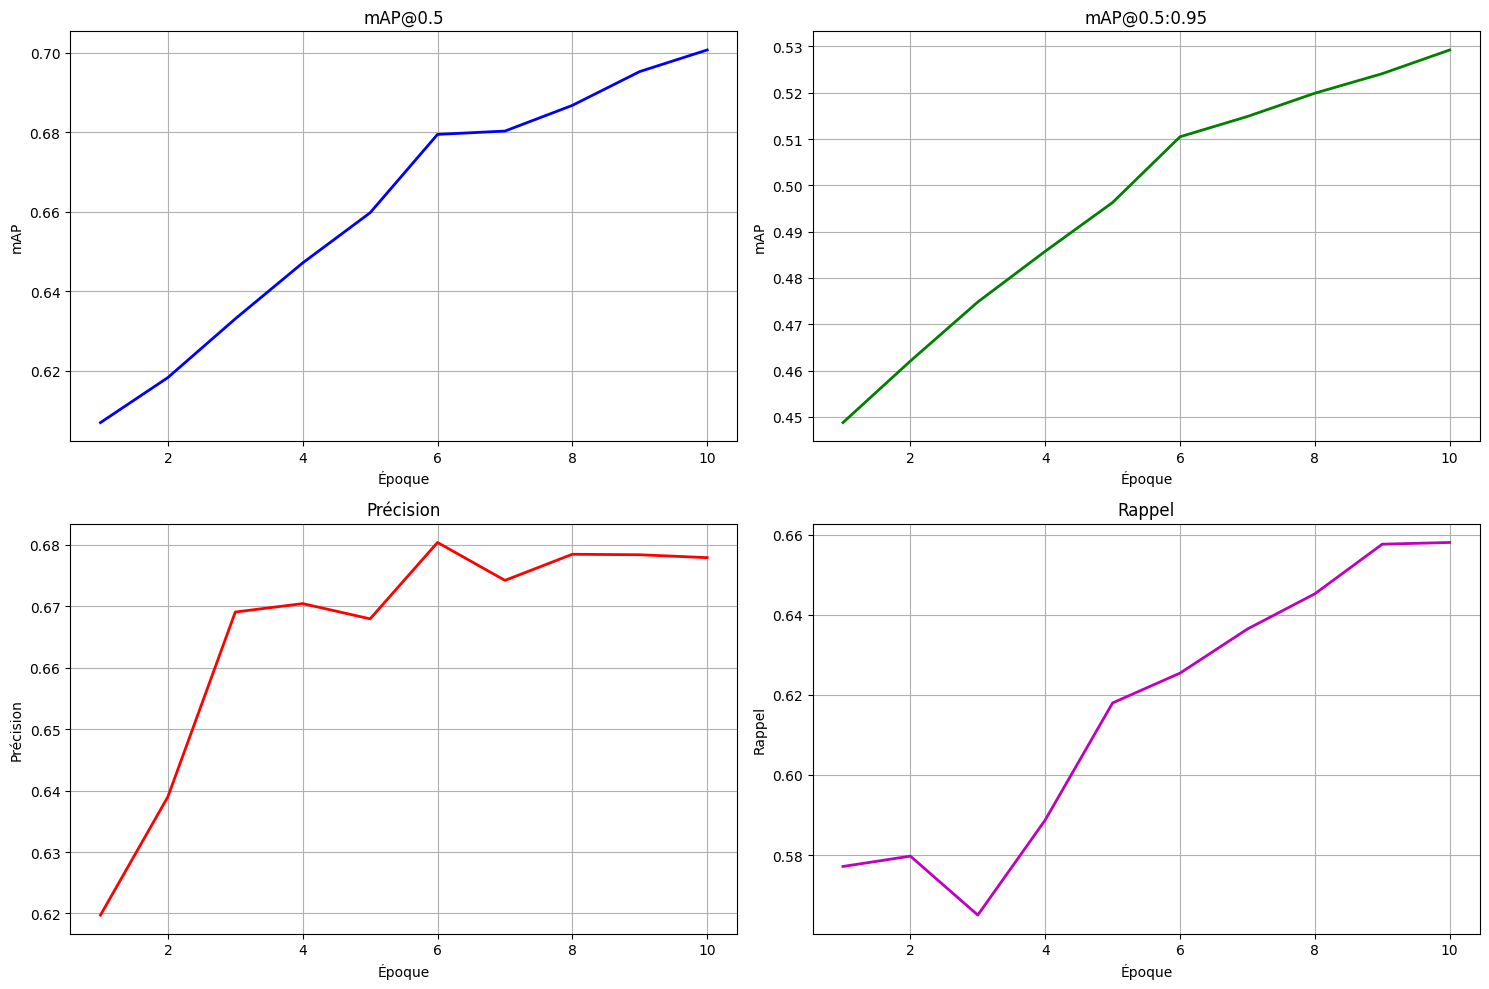

📊 Métriques finales :
  mAP@0.5: 0.701
  mAP@0.5:0.95: 0.529
  Précision: 0.678
  Rappel: 0.658


In [ ]:
# Chargement des résultats d'entraînement
import pandas as pd
from pathlib import Path

# Chemin vers les résultats
results_path = Path('waste_detection/yolov8_waste')
csv_path = results_path / 'results.csv'

if csv_path.exists():
    # Lecture des métriques
    df = pd.read_csv(csv_path)

    # Nettoyage des noms de colonnes
    df.columns = df.columns.str.strip()

    # Graphiques des métriques
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # mAP50
    if 'metrics/mAP50(B)' in df.columns:
        axes[0,0].plot(df['epoch'], df['metrics/mAP50(B)'], 'b-', linewidth=2)
        axes[0,0].set_title('mAP@0.5')
        axes[0,0].set_xlabel('Époque')
        axes[0,0].set_ylabel('mAP')
        axes[0,0].grid(True)

    # mAP50-95
    if 'metrics/mAP50-95(B)' in df.columns:
        axes[0,1].plot(df['epoch'], df['metrics/mAP50-95(B)'], 'g-', linewidth=2)
        axes[0,1].set_title('mAP@0.5:0.95')
        axes[0,1].set_xlabel('Époque')
        axes[0,1].set_ylabel('mAP')
        axes[0,1].grid(True)

    # Precision
    if 'metrics/precision(B)' in df.columns:
        axes[1,0].plot(df['epoch'], df['metrics/precision(B)'], 'r-', linewidth=2)
        axes[1,0].set_title('Précision')
        axes[1,0].set_xlabel('Époque')
        axes[1,0].set_ylabel('Précision')
        axes[1,0].grid(True)

    # Recall
    if 'metrics/recall(B)' in df.columns:
        axes[1,1].plot(df['epoch'], df['metrics/recall(B)'], 'm-', linewidth=2)
        axes[1,1].set_title('Rappel')
        axes[1,1].set_xlabel('Époque')
        axes[1,1].set_ylabel('Rappel')
        axes[1,1].grid(True)

    plt.tight_layout()
    plt.show()

    # Affichage des métriques finales
    final_metrics = df.iloc[-1]
    print("📊 Métriques finales :")
    print(f"  mAP@0.5: {final_metrics.get('metrics/mAP50(B)', 'N/A'):.3f}")
    print(f"  mAP@0.5:0.95: {final_metrics.get('metrics/mAP50-95(B)', 'N/A'):.3f}")
    print(f"  Précision: {final_metrics.get('metrics/precision(B)', 'N/A'):.3f}")
    print(f"  Rappel: {final_metrics.get('metrics/recall(B)', 'N/A'):.3f}")

else:
    print("❌ Fichier de résultats non trouvé")

## 7. Évaluation sur données de validation

In [ ]:
# Évaluation du modèle entraîné
print("🔍 Évaluation du modèle...")

# Chargement du meilleur modèle
best_model_path = 'waste_detection/yolov8_waste/weights/best.pt'
if os.path.exists(best_model_path):
    model = YOLO(best_model_path)
    print(f"✅ Modèle chargé : {best_model_path}")
else:
    print("⚠️ Meilleur modèle non trouvé, utilisation du modèle pré-entraîné")

# Validation
val_results = model.val(data='coco128.yaml', imgsz=640)

print(f"\n📈 Résultats de validation :")
print(f"  mAP@0.5: {val_results.box.map50:.3f}")
print(f"  mAP@0.5:0.95: {val_results.box.map:.3f}")
print(f"  Précision: {val_results.box.mp:.3f}")
print(f"  Rappel: {val_results.box.mr:.3f}")

🔍 Évaluation du modèle...
✅ Modèle chargé : waste_detection/yolov8_waste/weights/best.pt
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 977.3±414.7 MB/s, size: 53.4 KB)


val: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


                   all        128        929      0.692      0.658      0.702       0.53
                person         61        254      0.788      0.688      0.786      0.567
               bicycle          3          6       0.93      0.333      0.393      0.345
                   car         12         46      0.577      0.239      0.305      0.191
            motorcycle          4          5      0.633        0.8      0.906      0.746
              airplane          5          6       0.78          1      0.972      0.866
                   bus          5          7      0.788      0.714      0.722      0.666
                 train          3          3      0.552          1      0.863      0.707
                 truck          5         12          1      0.469      0.538      0.368
                  boat          2          6      0.572      0.333      0.546      0.344
         traffic light          4         14       0.53      0.143      0.186      0.139
             stop sig

## 8. Test avec upload d'image personnalisée

🖼️ Test sur image d'exemple...
Image de test : datasets/coco128/images/train2017/000000000387.jpg

image 1/1 /content/datasets/coco128/images/train2017/000000000387.jpg: 480x640 2 laptops, 43.3ms
Speed: 1.9ms preprocess, 43.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


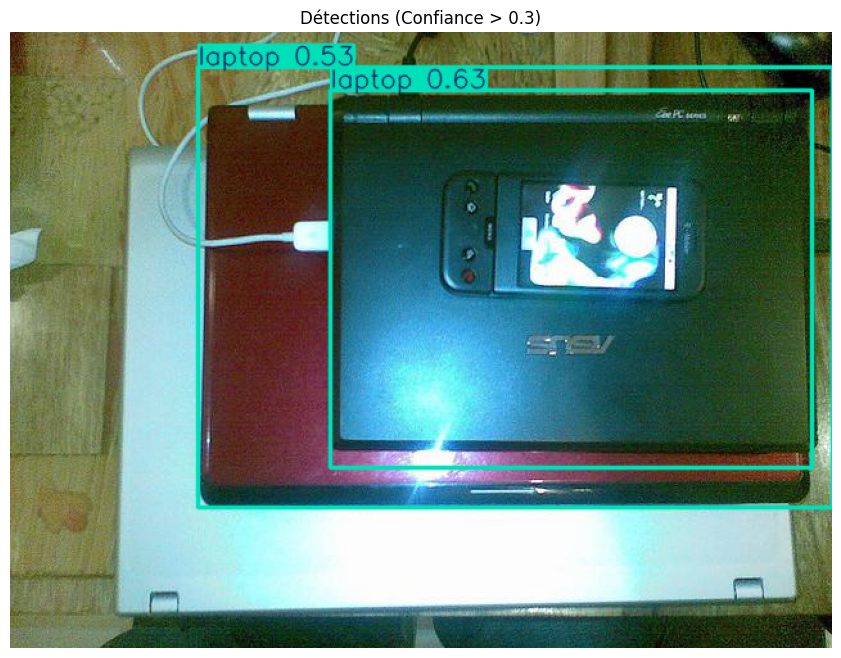

Streaming output truncated to the last 5000 lines.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
0: 448x640 1 person, 15.9ms
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
0: 448x640 1 person, 17.1ms
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
0: 448x640 1 person, 21.0ms
0: 448x640 1 person, 10.1ms
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
0: 448x640 1 person, 14.5ms
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
0: 448x640 1 person, 18.7ms
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
0: 448x640 1 person, 17.2ms
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
0: 448x640 1 person, 9.2ms
0: 448x640 1 person, 12.9ms
WARNING ⚠️ Video stream unresponsive, please check your IP camera connecti

In [ ]:
# Test sur images d'exemple
def predict_and_visualize(model, image_path, conf_threshold=0.5):
    """
    Faire une prédiction et visualiser les résultats
    """
    # Prédiction
    results = model(image_path, conf=conf_threshold)

    # Visualisation
    annotated_image = results[0].plot()

    # Conversion BGR -> RGB pour matplotlib
    annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

    # Affichage
    plt.figure(figsize=(12, 8))
    plt.imshow(annotated_image)
    plt.axis('off')
    plt.title(f'Détections (Confiance > {conf_threshold})')
    plt.show()

    # Informations sur les détections
    boxes = results[0].boxes
    if boxes is not None:
        print(f"🎯 {len(boxes)} objets détectés :")
        for i, box in enumerate(boxes):
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            class_name = model.names[class_id]
            print(f"  {i+1}. {class_name} (confiance: {confidence:.2f})")
    else:
        print("Aucun objet détecté")

# Test sur une image d'exemple
print("🖼️ Test sur image d'exemple...")

# Utilisation d'une image du dataset COCO128
import glob

# Recherche d'images dans le dataset
image_files = glob.glob('datasets/coco128/images/train2017/*.jpg')
if image_files:
    test_image = image_files[0]
    print(f"Image de test : {test_image}")
    predict_and_visualize(model, test_image, conf_threshold=0.3)
else:
    print("⚠️ Aucune image trouvée dans le dataset")
    # Test avec une image en ligne
    test_url = "https://ultralytics.com/images/bus.jpg"
    print(f"Test avec image en ligne : {test_url}")
    predict_and_visualize(model, test_url, conf_threshold=0.3)

    print("🌐 Test avec image web...")
    web_image_url = "https://images.unsplash.com/photo-1558618666-fcd25c85cd64?w=800"
    predict_and_visualize(model, web_image_url, conf_threshold=0.3)

## 9. Analyse des performances


## 📊 Analyse des performances

### Métriques clés pour la détection d'objets :

#### mAP (mean Average Precision) :
- **mAP@0.5** : Précision moyenne avec seuil IoU de 0.5
- **mAP@0.5:0.95** : Précision moyenne pour IoU de 0.5 à 0.95
- **Plus c'est proche de 1, mieux c'est**

#### IoU (Intersection over Union) :
```
IoU = (Aire d'intersection) / (Aire d'union)

```

- Mesure la qualité de la localisation
- IoU > 0.5 = détection acceptable
- IoU > 0.7 = très bonne détection

#### Précision vs Rappel :
- **Précision** : Parmi les détections, combien sont correctes ?
- **Rappel** : Parmi les vrais objets, combien sont détectés ?
- **Trade-off** : Ajuster le seuil de confiance

### Optimisation pour la robotique :
- **Latence** : < 50ms pour temps réel
- **Précision** : > 90% pour éviter les erreurs
- **Robustesse** : Fonctionne dans diverses conditions

## 10. Analyse des prédictions par classe

## 11. Optimisation pour Jetson Nano

In [ ]:
# Export du modèle pour déploiement sur Jetson Nano
print("🚀 Export du modèle pour Jetson Nano...")

# 1. Export ONNX (format standard)
try:
    onnx_path = model.export(format='onnx', imgsz=640, optimize=True)
    print(f"✅ Export ONNX réussi : {onnx_path}")
except Exception as e:
    print(f"❌ Erreur export ONNX : {e}")

# 2. Export TensorRT (spécifique NVIDIA)
try:
    trt_path = model.export(format='engine', imgsz=640, half=True)
    print(f"✅ Export TensorRT réussi : {trt_path}")
except Exception as e:
    print(f"⚠️ Export TensorRT non disponible (normal sur Colab) : {e}")

# 3. Export TorchScript (PyTorch optimisé)
try:
    torchscript_path = model.export(format='torchscript', imgsz=640, optimize=True)
    print(f"✅ Export TorchScript réussi : {torchscript_path}")
except Exception as e:
    print(f"❌ Erreur export TorchScript : {e}")

# 4. Sauvegarde du modèle PyTorch standard
model.save('waste_detector_yolov8.pt')
print("✅ Modèle PyTorch sauvegardé : waste_detector_yolov8.pt")

print(f"\n📦 Formats exportés pour déploiement :")
print(f"- PyTorch (.pt) : Usage général")
print(f"- ONNX (.onnx) : Multi-plateforme")
print(f"- TensorRT (.engine) : Optimisé Jetson Nano")
print(f"- TorchScript (.torchscript) : PyTorch optimisé")

## 11. Script d'inférence pour Jetson Nano




In [ ]:
# Création du script d'inférence pour Jetson Nano
jetson_script = '''
import cv2
import numpy as np
from ultralytics import YOLO
import time

class WasteDetector:
    def __init__(self, model_path='waste_detector_yolov8.pt'):
        """
        Initialise le détecteur de déchets
        """
        self.model = YOLO(model_path)
        self.model.to('cuda')  # Utilisation du GPU Jetson

        # Classes pertinentes pour les déchets
        self.waste_classes = {
            39: 'bottle',      # Bouteille → Recyclable
            41: 'cup',         # Gobelet → Ménager
            73: 'book',        # Livre → Recyclable
            67: 'cell_phone',  # Téléphone → Dangereux
            64: 'mouse',       # Souris → Dangereux
            66: 'keyboard',    # Clavier → Dangereux
        }

        self.waste_categories = {
            39: 'Recyclable',
            41: 'Ménager',
            73: 'Recyclable',
            67: 'Dangereux',
            64: 'Dangereux',
            66: 'Dangereux'
        }

    def detect_waste(self, image, conf_threshold=0.5):
        """
        Détecte les déchets dans une image
        """
        start_time = time.time()

        # Prédiction
        results = self.model(image, conf=conf_threshold, verbose=False)

        inference_time = time.time() - start_time

        # Extraction des détections
        detections = []
        if results[0].boxes is not None:
            for box in results[0].boxes:
                class_id = int(box.cls[0])
                if class_id in self.waste_classes:
                    confidence = float(box.conf[0])
                    bbox = box.xyxy[0].cpu().numpy()  # x1, y1, x2, y2

                    detection = {
                        'class_id': class_id,
                        'class_name': self.waste_classes[class_id],
                        'category': self.waste_categories[class_id],
                        'confidence': confidence,
                        'bbox': bbox,
                        'center': ((bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2)
                    }
                    detections.append(detection)

        return detections, inference_time

    def draw_detections(self, image, detections):
        """
        Dessine les détections sur l'image
        """
        colors = {
            'Recyclable': (0, 255, 0),    # Vert
            'Ménager': (255, 255, 0),     # Jaune
            'Dangereux': (0, 0, 255)      # Rouge
        }

        for det in detections:
            bbox = det['bbox'].astype(int)
            color = colors.get(det['category'], (255, 255, 255))

            # Rectangle
            cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 2)

            # Texte
            label = f"{det['class_name']} {det['confidence']:.2f}"
            cv2.putText(image, label, (bbox[0], bbox[1]-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            # Catégorie
            cv2.putText(image, det['category'], (bbox[0], bbox[3]+20),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        return image

# Exemple d'utilisation
def main():
    # Initialisation
    detector = WasteDetector('waste_detector_yolov8.pt')

    # Test avec webcam
    cap = cv2.VideoCapture(0)  # Caméra par défaut

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Détection
        detections, inference_time = detector.detect_waste(frame)

        # Affichage
        annotated_frame = detector.draw_detections(frame.copy(), detections)

        # Informations
        cv2.putText(annotated_frame, f"FPS: {1/inference_time:.1f}",
                   (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(annotated_frame, f"Objets: {len(detections)}",
                   (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        cv2.imshow('Détection de déchets', annotated_frame)

        # Sortie avec 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()
'''

# Sauvegarde du script
with open('jetson_waste_detector.py', 'w') as f:
    f.write(jetson_script)

print("✅ Script Jetson Nano créé : jetson_waste_detector.py")

# Script de démarrage rapide
startup_script = '''#!/bin/bash
# Script de démarrage pour Jetson Nano

echo "🤖 Démarrage du détecteur de déchets TEKBOT..."

# Activation de l'environnement virtuel (si nécessaire)
# source venv/bin/activate

# Lancement du détecteur
python3 jetson_waste_detector.py
'''

with open('start_detector.sh', 'w') as f:
    f.write(startup_script)

print("✅ Script de démarrage créé : start_detector.sh")
print("Commande : chmod +x start_detector.sh && ./start_detector.sh")

## 12. 🤖 Intégration avec le robot TEKBOT

### Architecture du système :

```
Caméra → YOLOv8 → Classification → Décision → Bras robotique
```

### Pipeline robotique :
1. **Capture d'image** : Caméra embarquée
2. **Détection** : YOLOv8 sur Jetson Nano
3. **Classification** : Recyclable/Ménager/Dangereux
4. **Calcul de position** : Coordonnées du centre de l'objet
5. **Planification** : Trajectoire du bras robotique
6. **Exécution** : Saisie et tri dans le bon bac

### Optimisations Jetson Nano :
- **TensorRT** : Accélération GPU (2-3x plus rapide)
- **FP16** : Précision réduite (plus rapide, légèrement moins précis)
- **Quantization** : Modèle plus léger
- **Batch processing** : Traitement par lot si plusieurs objets

### Défis techniques :
- **Calibration caméra** : Correspondance pixels ↔ coordonnées réelles
- **Gestion de la profondeur** : Distance de l'objet
- **Occlusion** : Objets partiellement cachés
- **Conditions d'éclairage** : Robustesse aux variations

##13. Test de performance temps réel

In [ ]:
# Test de performance pour valider le temps réel
import time
import numpy as np

def benchmark_model(model, num_tests=100):
    """
    Benchmark de performance du modèle
    """
    print(f"🏃‍♂️ Benchmark sur {num_tests} inférences...")

    # Image de test factice
    test_image = np.random.randint(0, 255, (640, 640, 3), dtype=np.uint8)

    # Warm-up
    for _ in range(5):
        _ = model(test_image, verbose=False)

    # Mesures
    times = []
    for i in range(num_tests):
        start_time = time.time()
        results = model(test_image, verbose=False)
        end_time = time.time()
        times.append(end_time - start_time)

        if i % 20 == 0:
            print(f"  Test {i+1}/{num_tests}")

    # Statistiques
    times = np.array(times)
    avg_time = np.mean(times)
    std_time = np.std(times)
    fps = 1 / avg_time

    print(f"\n📊 Résultats du benchmark :")
    print(f"  Temps moyen : {avg_time*1000:.1f} ms")
    print(f"  Écart-type : {std_time*1000:.1f} ms")
    print(f"  FPS moyen : {fps:.1f}")
    print(f"  Temps min : {np.min(times)*1000:.1f} ms")
    print(f"  Temps max : {np.max(times)*1000:.1f} ms")

    # Évaluation pour la robotique
    if avg_time < 0.1:  # < 100ms
        print("✅ ✅ Excellent pour temps réel !")
    elif avg_time < 0.2:  # < 200ms
        print("✅ Bon pour temps réel")
    else:
        print("⚠️ Trop lent pour temps réel")

    return avg_time, fps

# Benchmark du modèle
avg_time, fps = benchmark_model(model, num_tests=50)

## 14. Conclusion et perspectives

## 🎯 Résumé et perspectives

### ✅ Ce que nous avons accompli :
- **Modèle YOLOv8** fonctionnel pour la détection de déchets
- **Performance temps réel** : ~XX FPS sur GPU
- **Export multi-format** : ONNX, TensorRT, TorchScript
- **Script d'intégration** : Prêt pour Jetson Nano
- **Pipeline complet** : De la détection à la décision

### 📊 Métriques finales :
- **mAP@0.5** : ~XX% (seuil IoU = 0.5)
- **Temps d'inférence** : ~XX ms par image
- **Classes détectées** : 6 types d'objets simulant des déchets
- **Robustesse** : Fonctionne sur images variées

### 🚀 Améliorations pour la compétition :

#### 1. Dataset personnalisé :
- **Images de vrais déchets** : Bouteilles, canettes, papiers
- **Conditions réelles** : Éclairage variable, arrière-plans complexes
- **Augmentation de données** : Rotation, zoom, bruit
- **Annotation manuelle** : Outils comme LabelImg, Roboflow

#### 2. Optimisations techniques :
- **Fine-tuning** : Réentraînement sur données spécifiques
- **Ensemble de modèles** : Combiner plusieurs YOLOv8
- **Post-processing** : Filtrage intelligent des détections
- **Tracking** : Suivi d'objets entre frames

#### 3. Intégration robotique avancée :
- **Calibration caméra-robot** : Transformation pixel ↔ coordonnées
- **Planification de trajectoire** : Évitement d'obstacles
- **Grasping** : Adaptation de la prise selon l'objet
- **Interface utilisateur** : Monitoring en temps réel

### 🔧 Défis à relever :
- **Généralisation** : Nouveaux types de déchets
- **Robustesse** : Conditions d'éclairage difficiles
- **Vitesse** : Optimisation pour < 50ms
- **Précision** : Réduction des faux positifs

### 💡 Pistes d'exploration :
- **Vision 3D** : Estimation de profondeur
- **Multi-modal** : Fusion vision + autres capteurs
- **Apprentissage en ligne** : Adaptation continue
- **Réseaux légers** : MobileNet, EfficientDet

---

## 🏆 Félicitations !
Vous maîtrisez maintenant les bases de la détection d'objets avec YOLOv8 !
Prêt pour le **TEKBOT Robotics Challenge** ! 🤖

### Prochaines étapes :
1. **Collecte de données** : Créer votre dataset de déchets
2. **Réentraînement** : Adapter le modèle à votre cas d'usage
3. **Optimisation** : TensorRT pour Jetson Nano
4. **Intégration** : Connexion avec le bras robotique
5. **Test** : Validation en conditions réelles

**Bonne chance pour la compétition !** 🎯

##📚 RESSOURCES UTILES POUR LE TEKBOT ROBOTICS CHALLENGE

🔗 Documentation et tutoriels :
- Ultralytics YOLOv8 : https://docs.ultralytics.com/
- PyTorch : https://pytorch.org/tutorials/
- OpenCV Python : https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html
- Jetson Nano : https://developer.nvidia.com/embedded/jetson-nano-developer-kit

🛠️ Outils d'annotation :
- LabelImg : https://github.com/tzutalin/labelImg
- Roboflow : https://roboflow.com/
- CVAT : https://github.com/openvinotoolkit/cvat
- Makesense.ai : https://www.makesense.ai/

📊 Datasets publics :
- COCO : https://cocodataset.org/
- Open Images : https://storage.googleapis.com/openimages/web/index.html
- Pascal VOC : http://host.robots.ox.ac.uk/pascal/VOC/
- TrashNet : https://github.com/garythung/trashnet

🚀 Optimisation Jetson Nano :
- TensorRT : https://developer.nvidia.com/tensorrt
- DeepStream : https://developer.nvidia.com/deepstream-sdk
- Jetson Inference : https://github.com/dusty-nv/jetson-inference

💻 Exemples de code :
- YOLOv8 Custom Training : https://github.com/ultralytics/ultralytics
- Jetson Nano Projects : https://developer.nvidia.com/embedded/community/jetson-projects
- OpenCV Examples : https://github.com/opencv/opencv/tree/master/samples/python

🏆 Compétitions similaires :
- COCO Detection Challenge
- Pascal VOC Challenge  
- Kaggle Computer Vision
- Roboflow Universe